In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Предобработка данных из прошлого ноутбука

In [2]:
row_data = pd.read_csv("training.csv")

In [3]:
def fill_price(df, col):
    # I'm not sure what is the best way to fill prices
    df[col].fillna(df[col].mean(), inplace = True)

In [4]:
def data_fillna(df):
    res = df.drop(['RefId', 'WheelTypeID'], axis = 1)
    # I'll drop Model for now, as I don't know how to correctly encode it.
    # Making 1063 labels with one hot encoding looks bad for me, as I would use knn.
    # The same for Trim and SubModel, maybe I would need some text processing later
    # to extract features from SubModel such as 'Wagon', 'Sedan', 'Sport' etc, but I'm not there yet
    res = res.drop(['Model', 'Trim', 'SubModel'], axis = 1) 
    
    res['WheelType'].fillna('NotSpecified', inplace = True)
    
    res['PRIMEUNIT'].fillna("NO", inplace = True)
    res['AUCGUART'].fillna('RED', inplace = True)
    
    primeunit = {'NO': 0, 'YES': 1}
    # yellow exists in dataset description
    # we assume that RED < YELLOW < GREEN
    aucguart = {'RED': -1, 'YELLOW': 0, 'GREEN': 1} 
    
    res['PRIMEUNIT'].replace(primeunit, inplace = True)
    res['AUCGUART'].replace(aucguart, inplace = True)
    
    res['TopThreeAmericanName'].fillna('OTHER', inplace = True)

    res['AutoTransmition'] = res.apply(lambda t: t['Transmission'] == 'AUTO', axis = 1).astype(np.int64)
    res = res.drop('Transmission', axis = 1)
    
    # maybe we can do better, but as we have only 5 instances without Size, lets do stupid things
    res['Size'].fillna('MEDIUM', inplace = True) 
    
    # I think VNST gives enough information about state
    # as VNST zipcode is categorial feature, but with more instances, so I'll remove it
    res = res.drop('VNZIP1', axis = 1)
    
    # I don't really understand this feature, so, I'll ignore it for now, 
    # As it will grow my feature space to 74 features
    res = res.drop('BYRNO', axis = 1)
    
    res['Nationality'].fillna('OTHER', inplace = True)
    
    res['Color'].fillna('NOT AVAIL', inplace = True)
    
    fill_price(res, "MMRAcquisitionAuctionAveragePrice")
    fill_price(res, "MMRAcquisitionAuctionCleanPrice")
    fill_price(res, "MMRAcquisitionRetailAveragePrice")
    fill_price(res, "MMRAcquisitonRetailCleanPrice")
    fill_price(res, "MMRCurrentAuctionAveragePrice")
    fill_price(res, "MMRCurrentAuctionCleanPrice")
    fill_price(res, "MMRCurrentRetailAveragePrice")
    fill_price(res, "MMRCurrentRetailCleanPrice")
    
    res['PurchDate'] = (pd.to_datetime(res['PurchDate']).astype(np.int64)/ 10**9).astype(np.int64)
    
    return res

In [5]:
preprocessed_data = data_fillna(row_data)

так как объектов слишком много, и обучение слишком долгое, я в любом случае обрезал бы датасет. но можно попробовать сделать это с пользой, сбалансировав классы

In [6]:
from sklearn.utils import resample
df_majority = preprocessed_data[preprocessed_data.IsBadBuy==0]
df_minority = preprocessed_data[preprocessed_data.IsBadBuy==1]

In [7]:
df_minority.shape[0]

8976

In [8]:
df_majority_downsampled = resample(df_majority, replace=False,n_samples=df_minority.shape[0], random_state=123) 

In [9]:
preprocessed_data = pd.concat([df_majority_downsampled, df_minority])

In [10]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

def final_data_preparation(df):
    nonbinary_cols = list(filter(lambda c: df[c].dtype == object, df.columns))
    data_nonbinary = pd.get_dummies(df[nonbinary_cols])
    tmp = df.drop(nonbinary_cols, axis=1)
    tmp = pd.concat((tmp, data_nonbinary), axis = 1)
    # we normalize also binary data, assuming it is [0, 1]
    y = tmp['IsBadBuy'].get_values()
    X = tmp.drop('IsBadBuy', axis = 1).get_values()
    X = min_max_scaler.fit_transform(X)
    return (X, y)

In [11]:
X, y = final_data_preparation(preprocessed_data)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Использование нейронной сети 

In [13]:
from sklearn.neural_network import MLPClassifier

# Используем нейронную сеть со 100 нейронами и разными параметрами альфа. (взял из примера)

In [14]:
alpha_arr = np.logspace(-3, 2, 25)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

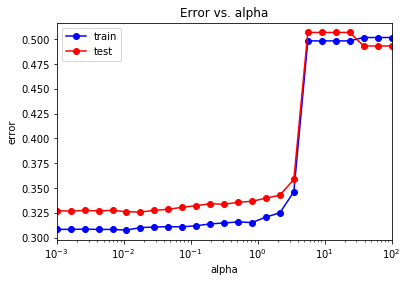

In [15]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

**Вывод: при малых значениях параметра alpha ошибка минимальна**

# Построим график зависимости ошибки от числа нейронов

In [16]:
n_arr = np.linspace(1, 1000, 25, dtype=int)
test_err = []
train_err = []
for n in n_arr:
    mlp_model = MLPClassifier(alpha = 0.1, hidden_layer_sizes = (n,), activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

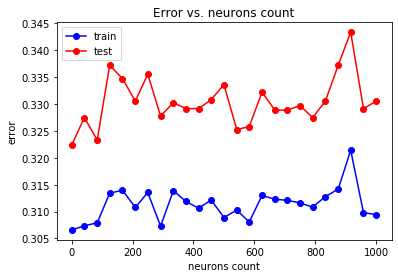

In [17]:
plt.plot(n_arr, train_err, 'b-o', label = 'train')
plt.plot(n_arr, test_err, 'r-o', label = 'test')
plt.title('Error vs. neurons count')
plt.xlabel('neurons count')
plt.ylabel('error')
plt.legend()
pass

In [18]:
configurations = [
    (1000,),
    (500, 500,),
    (333, 333, 334,),
    (250, 250, 250, 250),
]
test_err = []
train_err = []
for c in configurations:
    mlp_model = MLPClassifier(alpha = 0.1, hidden_layer_sizes = c, activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

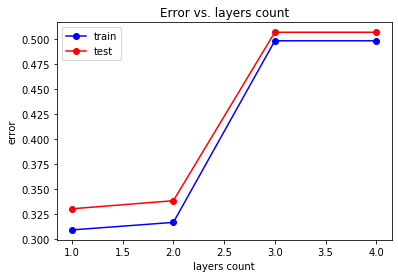

In [19]:
plt.plot(list(range(1, 5)), train_err, 'b-o', label = 'train')
plt.plot(list(range(1, 5)), test_err, 'r-o', label = 'test')
plt.title('Error vs. layers count')
plt.xlabel('layers count')
plt.ylabel('error')
plt.legend()
pass

Вывод:  
Нет четкой связи между количеством нейронов и ошибкой.  
При равном числе нейронов, увеличение слоев увеличивает ошибку.

# Применим PCA

In [27]:
mlp_model = MLPClassifier(alpha = 0.1, hidden_layer_sizes = (1000, ), activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components=30)
mlp_model = MLPClassifier(alpha = 0.1, hidden_layer_sizes = (1000, ), activation = 'logistic', random_state = 42)

pca.fit(X_train)
mlp_model.fit(pca.transform(X_train), y_train)
y_train_pred_pca = mlp_model.predict(pca.transform(X_train))
y_test_pred_pca = mlp_model.predict(pca.transform(X_test))

print("Without PCA: ", np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))
print("Wit PCA:     ", np.mean(y_train != y_train_pred_pca), np.mean(y_test != y_test_pred_pca))

from sklearn.metrics import confusion_matrix

print("Without PCA: \n", confusion_matrix(y_test, y_test_pred))

print("Wit PCA: \n", confusion_matrix(y_test, y_test_pred_pca))

Without PCA:  0.30944920270176174 0.3305485937064884
Wit PCA:      0.32483810319615625 0.33778891673628514
Without PCA: 
 [[1262  509]
 [ 678 1142]]
Wit PCA: 
 [[1424  347]
 [ 866  954]]


Вывод: ошибка с PCA увеличилась не сильно, а количество признаков уменьшилось в 3 раза 